# Background and Objectives

## Background
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

## Objectives

The task starts with the data exploration where I have compared the monthly payment distribution (MonthlyCharges) of all active clients with the clients who have left and numerically documenting the statistical summary of these groups and visualizing the data distribution.

There is also a data split where the behavior of the Telephone Users and the Internet users are being compared. 
Then, I have trained the data of the client for predicting the customer churn and tested the data in the best performing model.


In [2]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

In [7]:
contract = pd.read_csv("/datasets/final_provider/contract.csv")
personal = pd.read_csv("/datasets/final_provider/personal.csv")
phone = pd.read_csv("/datasets/final_provider/phone.csv")
internet = pd.read_csv("/datasets/final_provider/internet.csv")

## Explore Dataset

### Explore all data files and look for duplicates

In [8]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [9]:
print("The number of duplicates in Contract dataframe is",contract.duplicated().sum())

The number of duplicates in Contract dataframe is 0


In [10]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [11]:
print("The number of duplicates in Personal dataframe is",personal.duplicated().sum())

The number of duplicates in Personal dataframe is 0


In [12]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
print("The number of duplicates in Internet dataframe is",internet.duplicated().sum())

The number of duplicates in Internet dataframe is 0


In [14]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [15]:
print("The number of duplicates in Phone dataframe is",phone.duplicated().sum())

The number of duplicates in Phone dataframe is 0


#### Conclusion

- There are no duplicated in all 4 dataframes**
- The contract dataframe contains the client's information on the contract plan such as start date, end date, plan type, payment method, payment amount, etc.
- The Personal dataframe contain client's demographic information
- The internet dataframe contains information on the internet service and other software and security services that clients are enrolled in.
- The Phone dataframe contains information on telephone service.





### Combine all data tables into 1 single dataframe

In [16]:
Data = contract.merge(personal, on="customerID", how='outer').merge(internet, on = "customerID",how='outer').merge(phone, on= "customerID",how='outer')
Data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


#### Conclusion
- Merged all data sources into 1 dataframe

### Convert all required columns to desired types such as convert dates columns from object to datetime in contract table.

In [17]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [18]:
Data['BeginDate'] = pd.to_datetime(Data['BeginDate'] )
Data['EndDate'] = pd.to_datetime(Data['EndDate'], errors = "ignore")
Data['TotalCharges'] = pd.to_numeric(Data['TotalCharges'], errors='coerce')
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

#### Conclusion

- Converted BeginDate and EndDate to datatime datatype, Total Charges to numeric datatype

### Compare the monthly payment distribution (MonthlyCharges) of all active clients with the clients who have left.

In [19]:
active = Data.query('EndDate == "No"')
active.shape

(5174, 20)

In [20]:
active.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN


In [21]:
active['EndDate'].unique()

array(['No'], dtype=object)

In [22]:
active['MonthlyCharges'].describe()

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

- There are 5174 active clients
- The average monthly spent of active client is \\$61
- The monthly minimum spent is \\$18 and the maximum spent is \\$119


array([[<AxesSubplot:title={'center':'MonthlyCharges'}>]], dtype=object)

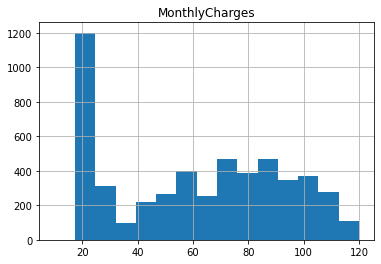

In [23]:
active.hist('MonthlyCharges', bins=15, range = (10,120))

In [24]:
inactive = Data.query('EndDate != "No"')
inactive.shape

(1869, 20)

In [25]:
inactive['MonthlyCharges'].describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

- 1869 clients ended the service
- The average monthly spent of inactive client is \\$74
- The monthly minimum spent is \\$18 and the maximum spent is \\$119

array([[<AxesSubplot:title={'center':'MonthlyCharges'}>]], dtype=object)

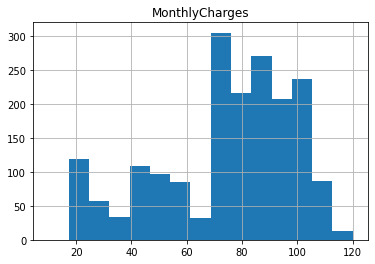

In [26]:
inactive.hist('MonthlyCharges', bins=15, range = (10,120))

#### Conclusion

- Sliced the dataframe into active and inactive clients data
- Calculated the statistical summary on monthly and total spent of both type of clients
   - There are 5174 active clients
   - The average monthly spent of active client is \\$61 which is lower than the monthly spent of the client who left (\\$74)
   - The monthly minimum spent is \\$18 and the maximum spent is \\$119 for both active and inactive clients
   - The active client's monthly spent distribution is not normally distributed. Looks like lost of the client paid around \\$20 for monthly bill but rest of the distribution look normal.
   - The inactive client's monthly spent distribution is very random. The reasons could be some of the client paid very high monthly bill while some paid very low due to the different services they were using.

## Compare the behavior of the telephone users and Internet users.

Separate data into 2 groups
Visualize the data to show the share of telephone users and the share of internet users

### Internet Users

In [27]:
Data['InternetService'].unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

In [28]:
Internetusers = Data.dropna(subset=['InternetService'])

In [29]:
Internetusers.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [30]:
Internetusers['MonthlyCharges'].describe()

count    5517.000000
mean       76.844254
std        21.924661
min        23.450000
25%        59.950000
50%        79.450000
75%        94.450000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [31]:
Internetusers['gender'].value_counts()

Male      2776
Female    2741
Name: gender, dtype: int64

In [32]:
print(Internetusers['PaperlessBilling'].value_counts())

Yes    3725
No     1792
Name: PaperlessBilling, dtype: int64


In [33]:
print(Internetusers['Type'].value_counts())

Month-to-month    3351
One year          1109
Two year          1057
Name: Type, dtype: int64


In [34]:
print(Internetusers['PaymentMethod'].value_counts())

Electronic check             2243
Bank transfer (automatic)    1212
Credit card (automatic)      1191
Mailed check                  871
Name: PaymentMethod, dtype: int64


array([[<AxesSubplot:title={'center':'MonthlyCharges'}>]], dtype=object)

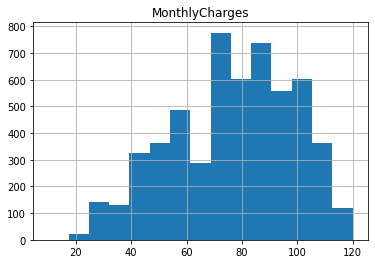

In [35]:
Internetusers.hist('MonthlyCharges', bins=15, range = (10,120))

### Telephone Users

In [36]:
Telephoneusers= (Data[Data.InternetService.isnull()])
Telephoneusers.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
11,7469-LKBCI,2018-10-01,No,Two year,No,Credit card (automatic),18.95,326.80,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
16,8191-XWSZG,2015-10-01,No,One year,No,Mailed check,20.65,1022.95,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
21,1680-VDCWW,2019-02-01,No,One year,No,Bank transfer (automatic),19.80,202.25,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
22,1066-JKSGK,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,20.15,20.15,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
33,7310-EGVHZ,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,20.20,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [37]:
Telephoneusers['MonthlyCharges'].describe()

count    1526.000000
mean       21.079194
std         2.164221
min        18.250000
25%        19.700000
50%        20.150000
75%        20.900000
max        26.900000
Name: MonthlyCharges, dtype: float64

In [38]:
Telephoneusers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1526 entries, 11 to 7037
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        1526 non-null   object        
 1   BeginDate         1526 non-null   datetime64[ns]
 2   EndDate           1526 non-null   object        
 3   Type              1526 non-null   object        
 4   PaperlessBilling  1526 non-null   object        
 5   PaymentMethod     1526 non-null   object        
 6   MonthlyCharges    1526 non-null   float64       
 7   TotalCharges      1520 non-null   float64       
 8   gender            1526 non-null   object        
 9   SeniorCitizen     1526 non-null   int64         
 10  Partner           1526 non-null   object        
 11  Dependents        1526 non-null   object        
 12  InternetService   0 non-null      object        
 13  OnlineSecurity    0 non-null      object        
 14  OnlineBackup      0 non

array([[<AxesSubplot:title={'center':'MonthlyCharges'}>]], dtype=object)

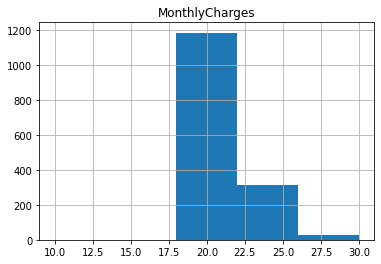

In [39]:
Telephoneusers.hist('MonthlyCharges', bins=5, range = (10,30))

In [40]:
Telephoneusers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1526 entries, 11 to 7037
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        1526 non-null   object        
 1   BeginDate         1526 non-null   datetime64[ns]
 2   EndDate           1526 non-null   object        
 3   Type              1526 non-null   object        
 4   PaperlessBilling  1526 non-null   object        
 5   PaymentMethod     1526 non-null   object        
 6   MonthlyCharges    1526 non-null   float64       
 7   TotalCharges      1520 non-null   float64       
 8   gender            1526 non-null   object        
 9   SeniorCitizen     1526 non-null   int64         
 10  Partner           1526 non-null   object        
 11  Dependents        1526 non-null   object        
 12  InternetService   0 non-null      object        
 13  OnlineSecurity    0 non-null      object        
 14  OnlineBackup      0 non

In [41]:
print(Telephoneusers['gender'].value_counts())
print(Telephoneusers['Type'].value_counts())

Male      779
Female    747
Name: gender, dtype: int64
Two year          638
Month-to-month    524
One year          364
Name: Type, dtype: int64


In [42]:
print(Telephoneusers['PaymentMethod'].value_counts())

Mailed check                 741
Bank transfer (automatic)    332
Credit card (automatic)      331
Electronic check             122
Name: PaymentMethod, dtype: int64


In [43]:
print(Telephoneusers['PaperlessBilling'].value_counts())

No     1080
Yes     446
Name: PaperlessBilling, dtype: int64


#### Conclusion
   - There are ~5500 internet users and ~1500 Telephone users only
   - There is almost 50/50 gender split among both Internet and telephone users
   - Majority of Internet users pay their bills in monthly basis while most of the Telephone users pay their bills for 2 years
   - Majority of Internet users opt out for paperless billings; however over 72% of Telephone users are getting their bills in the mail. Almost 50% of telephone users pay their bills via mailed checks while some use Bank Transfer and Credit cards as automatic payments. Electronic check is the least used payment method among the telephone users. On the other hand, interestingly, Electronic Check is the most used payment method among the Internet users and mailed check is the least used payment method which is right opposite.
   - Telephone users spent at least \\$18 monthly. The highest spent by telephone users was \\$27 and the average was \\$21
   - Internet users spent at least \\$60 monthly. The highest spent by internet users was \\$27 and the average was \\$77
   - In average Internet users spent more than 3 times of telephone users and Internet users spent 5 times as much as the telephone users spent in monthly service
      

## Model Training and Testing

In [44]:
Data = Data.fillna(value='No')

In [45]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

In [46]:
def client(row):
    active = row['EndDate']
    
    if active != "No":
        return 0
    return 1

In [47]:
Data['status'] = Data.apply(client,axis=1)

In [48]:
Data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,status
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,1
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


In [49]:
data = Data.drop(['customerID','BeginDate','EndDate','SeniorCitizen'], axis=1)

**One Hot Endcoding**

In [50]:
data_ohe = pd.get_dummies(data, drop_first=True)
target = data_ohe['status']
features = data_ohe.drop('status', axis=1)

In [51]:
target.value_counts()

1    5174
0    1869
Name: status, dtype: int64

**Split the dataset to train_test**

In [52]:
features_train,feature_rem,target_train, target_rem = train_test_split(features,target,train_size=0.60,random_state=12345)
features_valid,features_test,target_valid,target_test = train_test_split(feature_rem,target_rem, test_size=0.5,random_state=12345)

### Model Training

#### Logistic Regression

In [55]:
model = LogisticRegression(random_state=12345,solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

probabilities_test = model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_valid,probabilities_one_test)

print(auc_roc)


F1: 0.855650522317189
0.8357782286637744


#### Decision Tree Classifier

In [56]:
model = DecisionTreeClassifier(random_state=12345,class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print(f1_score(target_valid,predicted_valid))

probabilities_test = model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_valid,probabilities_one_test)

print(auc_roc)

0.815267175572519
0.7107023965497026


#### Random Forest Classifier

In [57]:
for estimators in range(1,10):
    model = RandomForestClassifier(random_state=12345, n_estimators=estimators)
    fit=model.fit(features_train, target_train)
    predicted_valid = fit.predict(features_valid)
    
    print("estimators =", estimators, "F1 Score: ", end='')
    print(f1_score(target_valid, predicted_valid))

estimators = 1 F1 Score: 0.806171648987464
estimators = 2 F1 Score: 0.7799472295514512
estimators = 3 F1 Score: 0.8344370860927153
estimators = 4 F1 Score: 0.8186785891703924
estimators = 5 F1 Score: 0.8400374181478016
estimators = 6 F1 Score: 0.8347826086956522
estimators = 7 F1 Score: 0.8447955390334574
estimators = 8 F1 Score: 0.8406072106261859
estimators = 9 F1 Score: 0.846971798428109


#### CatBoost Classifier

In [58]:
clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)

clf.fit(features_train, target_train,  
        eval_set=(features_valid, target_valid), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'learning_rate': 0.1}


In [59]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(
    iterations=5,
    random_state=12345,
    learning_rate=0.1,
    custom_loss=['AUC', 'Accuracy']
)

clf.fit(
    features_train, target_train, 
    eval_set=(features_valid, target_valid),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

**Upsampling the training set**

In [61]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train== 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

In [62]:
print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(1101, 6549)
(3124, 6549)
(1101,)
(3124,)


In [63]:
features_upsampled = pd.concat([features_ones] + [features_zeros] * 3)
target_upsampled = pd.concat([target_ones] + [target_zeros] * 3)

In [64]:
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

In [65]:
print(features_upsampled.shape)
print(target_upsampled.shape)

(6427, 6549)
(6427,)


In [66]:
features_zeros = features_upsampled[target_train == 0]
features_ones = features_upsampled[target_train == 1]
target_zeros = target_upsampled[target_train == 0]
target_ones = target_upsampled[target_train == 1]
print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(3303, 6549)
(3124, 6549)
(3303,)
(3124,)


/tmp/ipykernel_48/3641812669.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  features_zeros = features_upsampled[target_train == 0]
/tmp/ipykernel_48/3641812669.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  features_ones = features_upsampled[target_train == 1]


##### Logistic Regression on Upsampled training set

In [67]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled,target_upsampled)
predicted_valid= model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

probabilities_test = model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_valid,probabilities_one_test)

print(auc_roc)

F1: 0.8157614483493077
0.8366091956952849


##### Decision Tree Classifier on upsampled training set

In [69]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled,target_upsampled)
predicted_valid= model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

probabilities_test = model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_valid,probabilities_one_test)

print(auc_roc)

F1: 0.8098918083462133
0.7151643836314788


#### Random Forest Classifier on upsampled dataset

In [71]:
for estimators in range(1,30):
    model = RandomForestClassifier(random_state=12345, n_estimators=estimators)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
   
    
    print("Estimators =", estimators, "F1 Score: ", end='')
    print(f1_score(target_valid, predicted_valid))

Estimators = 1 F1 Score: 0.7912646013204673
Estimators = 2 F1 Score: 0.7355134825014342
Estimators = 3 F1 Score: 0.8122137404580153
Estimators = 4 F1 Score: 0.784524449220849
Estimators = 5 F1 Score: 0.815935451336359
Estimators = 6 F1 Score: 0.802088772845953
Estimators = 7 F1 Score: 0.8238835925740091
Estimators = 8 F1 Score: 0.8062015503875969
Estimators = 9 F1 Score: 0.8264132066033016
Estimators = 10 F1 Score: 0.8159509202453987
Estimators = 11 F1 Score: 0.831505483549352
Estimators = 12 F1 Score: 0.8189216683621567
Estimators = 13 F1 Score: 0.8266932270916335
Estimators = 14 F1 Score: 0.8213740458015266
Estimators = 15 F1 Score: 0.8317617866004963
Estimators = 16 F1 Score: 0.8252525252525253
Estimators = 17 F1 Score: 0.8313373253493013
Estimators = 18 F1 Score: 0.8280060882800608
Estimators = 19 F1 Score: 0.8333333333333334
Estimators = 20 F1 Score: 0.8308934881373043
Estimators = 21 F1 Score: 0.8355822088955522
Estimators = 22 F1 Score: 0.8307225871652351
Estimators = 23 F1 Scor

In [72]:
model = RandomForestClassifier(random_state=12345, max_depth = 50, n_estimators=200)

model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

probabilities_test = model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_valid,probabilities_one_test)

print(auc_roc)

F1: 0.8166491043203372
0.8270823880870934


#### CatBoost Classifier

In [73]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)

clf.fit(features_upsampled, target_upsampled,  
        eval_set=(features_valid, target_valid), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'learning_rate': 0.1}


In [75]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=100,
    random_state=12345,
    learning_rate=0.005,
    custom_loss=['AUC', 'Accuracy']
)

clf.fit(
    features_upsampled, target_upsampled, 
    eval_set=(features_valid, target_valid),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In the model training, the best performing model is Random Forest Classifier with 77% accuracy and 89% score on auc_roc when 9 estimators are used in the upsampled dataset.

### Model Testing

Picking the best model and parameters from previous step and measuring f1 score in test set

#### Random Forest Classifier in upsampled train set

In [76]:
model = RandomForestClassifier(random_state=12345,max_depth = 50, n_estimators=200)
model.fit(features_upsampled, target_upsampled)
predicted_test= model.predict(features_test)

print('F1:', f1_score(target_test, predicted_test))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test,probabilities_one_test)

print("AUC-ROC Score in the test set is",auc_roc)

F1: 0.8094488188976378
AUC-ROC Score in the test set is 0.7973867878180096


#### Random Forest Classifier in original trainset

In [77]:
model = RandomForestClassifier(random_state=12345,max_depth = 50, n_estimators=200)
model.fit(features_train, target_train)
predicted_test= model.predict(features_test)

print('F1:', f1_score(target_test, predicted_test))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test,probabilities_one_test)

print("AUC-ROC Score in the test set is",auc_roc)

F1: 0.8514588859416446
AUC-ROC Score in the test set is 0.7967245579647384


#### Logistic Regression in upsampled train set

In [78]:
model = LogisticRegression(random_state=12345,class_weight='balanced',solver='liblinear')
model.fit(features_upsampled,target_upsampled)
predicted_test= model.predict(features_test)

print('F1:', f1_score(target_test, predicted_test))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test,probabilities_one_test)

print("AUC-ROC Score in the test set is",auc_roc)

F1: 0.8059227921734531
AUC-ROC Score in the test set is 0.8088764124615704


#### Logistic Regression in original trainset

In [79]:
model = LogisticRegression(random_state=12345,class_weight='balanced',solver='liblinear')
model.fit(features_train,target_train)
predicted_test= model.predict(features_test)

print('F1:', f1_score(target_test, predicted_test))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test,probabilities_one_test)

print("AUC-ROC Score in the test set is",auc_roc)

F1: 0.8004257583821182
AUC-ROC Score in the test set is 0.8095804273725049


#### CatBoost Classifier in upsampled trainset

In [80]:
from catboost import CatBoostClassifier, Pool
eval_dataset = Pool(features_test, target_test)
clf = CatBoostClassifier(
    eval_metric = 'AUC',
    random_seed=42,
    learning_rate=0.3,
    iterations=50,
    max_depth=4,
    custom_metric=['Accuracy','AUC:hints=skip_train~false']

)

clf.fit(features_upsampled, target_upsampled,  
        eval_set=eval_dataset,
        verbose=False,
        plot=True
       )
print(clf.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'Accuracy': 0.785125252839583, 'Logloss': 0.4460237630576464, 'AUC': 0.8655796557895802}, 'validation': {'Accuracy': 0.7196593328601846, 'Logloss': 0.5294694377486461, 'AUC': 0.8109517369921849}}


#### CatBoost Classifier in original trainset

In [81]:
from catboost import CatBoostClassifier, Pool
eval_dataset = Pool(features_test, target_test)
clf = CatBoostClassifier(
    eval_metric = 'AUC',
    random_seed=42,
    learning_rate=0.3,
    iterations=50,
    max_depth=4,
    custom_metric=['Accuracy','AUC:hints=skip_train~false']

)

clf.fit(features_train, target_train,  
        eval_set=eval_dataset,
        verbose=False,
        plot=True
       )
print(clf.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'Accuracy': 0.7957396449704142, 'Logloss': 0.4029746589217374, 'AUC': 0.8578367239187749}, 'validation': {'Accuracy': 0.7771469127040455, 'Logloss': 0.46243162671982874, 'AUC': 0.8103946028900065}}


#### Conclusion

The best AUC score was achieved in CatBoost Classifier original dataset with 80% accuracy and 86% AUC_ROC score in learning and 81% AUC-ROC score in validation of test set.

## Detailed Conclusions

### Data Exploration and pre-processing



- The contract dataframe contains the client's information on the contract plan such as start date, end date, plan type, payment method, payment amount, etc.
- The Personal dataframe contain client's demographic information
- The internet dataframe contains information on the internet service and other software and security services that clients are enrolled in.
- The Phone dataframe contains information on telephone service.
- There are no duplicated in all 4 dataframes
- Merged all data sources into 1 dataframe
- Converted BeginDate and EndDate to datatime datatype, Total Charges to numeric datatype

### Compared the monthly payment distribution (MonthlyCharges) of all active clients with the clients who have left.

   - Sliced the dataframe into active and inactive clients data
   - Calculated the statistical summary on monthly and total spent of both type of clients
   - There are 5174 active clients
   - The average monthly spent of active client is \\$61 which is lower than the monthly spent of the client who left (\\$74)
   - The monthly minimum spent is \\$18 and the maximum spent is \\$119 for both active and inactive clients
   - The active client's monthly spent distribution is not normally distributed. Looks like lost of the client paid around \\$20 for monthly bill but rest of the distribution look normal.
   - The inactive client's monthly spent distribution is very random. The reasons could be some of the client paid very high monthly bill while some paid very low due to the different services they were using.
   
   
   
### Compare the behavior of the telephone users and Internet users
   - There are ~5500 internet users and ~1500 Telephone users only
   - There is almost 50/50 gender split among both Internet and telephone users
   - Majority of Internet users pay their bills in monthly basis while most of the Telephone users pay their bills for 2 years
   - Majority of Internet users opt out for paperless billings; however over 72% of Telephone users are getting their bills in the mail. Almost 50% of telephone users pay their bills via mailed checks while some use Bank Transfer and Credit cards as automatic payments. Electronic check is the least used payment method among the telephone users. On the other hand, interestingly, Electronic Check is the most used payment method among the Internet users and mailed check is the least used payment method which is right opposite.
   - Telephone users spent at least \\$18 monthly. The highest spent by telephone users was \\$27 and the average was \\$21
   - Internet users spent at least \\$60 monthly. The highest spent by internet users was \\$27 and the average was \\$77
   - In average Internet users spent more than 3 times of telephone users and Internet users spent 5 times as much as the telephone users spent in monthly service
      
      
### Model Training and Testing

   - Splited the dataset into train, valid and test set
   - Performed one hot encoding and replaced all Nans with No
   - Trained the model in Logistic Regression, Random Forest, CatBoost and Decision Tree Classifier using original dataset
   - Upsampled the zeros by 3 times so that we have a equal proportion of zeros and ones, splitted the upsampled data into train/validation and test set. Trained and tested the model with upsampled dataset as well as original dataset.
   - Took the best performing model for final evaluation.

  
 
**The best AUC score was achieved in CatBoost Classifier original dataset with 80% accuracy and 86% AUC_ROC score in learning and 81% AUC-ROC score in the validation of test set.**